# <font color='blue'>Imports </font>

In [1]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm
import optuna
import optuna.integration.lightgbm as lgb
import matplotlib.lines as line
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import sklearn.datasets as skd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss, brier_score_loss

Wall time: 1.78 s


In [2]:
%%time
path = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\'
dataset = pd.read_csv('{}combined_csv.csv'.format(path))

Wall time: 447 ms


In [3]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'ATK_Shields', 'DEF_Shields',
       'MapName', 'MatchID', 'SeriesID', 'bestOF', 'FinalWinner'],
      dtype='object')

# <font color='blue'> Predict variable </font>

In [6]:
selected_features = ['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                     'ATK_Shields', 'DEF_Shields',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']

predict_variable = 'FinalWinner'

### <font color='black'> Trimming dataframe </font>

In [7]:
dataset = dataset[selected_features]

if 'MapName' in dataset.columns:
    dataset = pd.get_dummies(dataset, columns=['MapName'])
    
X = dataset.drop([predict_variable], axis='columns')
Y = dataset[predict_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

In [8]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,2500,0,1,2,1,1,1,1,2,1,...,0,0,0,0,0,0,0,1,0,0
1,2500,0,1,2,1,1,1,0,2,1,...,0,21,0,0,0,0,0,1,0,0
2,2000,0,1,1,1,1,1,0,2,1,...,0,22,0,0,0,0,0,1,0,0
3,1500,0,1,0,1,1,1,0,2,1,...,0,24,0,0,0,0,0,1,0,0
4,1000,0,0,0,1,1,1,0,2,1,...,0,26,0,0,0,0,0,1,0,0


# <font color='blue'>Parameter tuning </font>

In [9]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [10]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-06-21 17:51:04,552] A new study created in memory with name: no-name-38900618-c308-4ebd-a14a-3790eae500e5


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-21 17:51:05,669] Trial 0 finished with value: 0.22479639296969978 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 58, 'max_depth': 10, 'learning_rate': 0.0013199693154153107, 'num_leaves': 52, 'num_threads': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 0 with value: 0.22479639296969978.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 17:51:08,323] Trial 1 finished with value: 0.13960882845068712 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 53, 'max_depth': 12, 'learning_rate': 0.018096471255362876, 'num_leaves': 46, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 1 with value: 0.13960882845068712.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:08,953] Trial 2 finished with value: 0.1817305310386413 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 59, 'max_depth': 9, 'learning_rate': 0.0062479952860826785, 'num_leaves': 9, 'num_threads': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 1 with value: 0.13960882845068712.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 17:51:09,623] Trial 3 finished with value: 0.20142777764875394 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 39, 'max_depth': 10, 'learning_rate': 0.0033688948469026863, 'num_leaves': 14, 'num_threads': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 1 with value: 0.13960882845068712.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-21 17:51:10,742] Trial 4 finished with value: 0.13134380440429388 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 92, 'max_depth': 13, 'learning_rate': 0.0377709005727766, 'num_leaves': 62, 'num_threads': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 4 with value: 0.13134380440429388.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 17:51:11,850] Trial 5 finished with value: 0.2159450924539825 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 72, 'max_depth': 19, 'learning_rate': 0.0022129058501855333, 'num_leaves': 11, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.13134380440429388.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 17:51:13,428] Trial 6 finished with value: 0.15020982681500245 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 22, 'max_depth': 11, 'learning_rate': 0.010875957195311045, 'num_leaves': 65, 'num_threads': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.13134380440429388.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:14,000] Trial 7 finished with value: 0.19764594704478008 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 33, 'max_depth': 17, 'learning_rate': 0.0041003105970031, 'num_leaves': 9, 'num_threads': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.13134380440429388.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 17:51:14,605] Trial 8 finished with value: 0.1323086532640794 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 14, 'max_depth': 16, 'learning_rate': 0.0768559376519073, 'num_leaves': 11, 'num_threads': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.13134380440429388.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 17:51:15,489] Trial 9 finished with value: 0.19719053640226805 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 56, 'max_depth': 12, 'learning_rate': 0.0032557780483616905, 'num_leaves': 63, 'num_threads': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.13134380440429388.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-21 17:51:16,014] Trial 10 finished with value: 0.1429213866182713 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 97, 'max_depth': 2, 'learning_rate': 0.0435147397680808, 'num_leaves': 28, 'num_threads': 8, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.13134380440429388.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 17:51:16,928] Trial 11 finished with value: 0.12945485173848084 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 4, 'max_depth': 16, 'learning_rate': 0.0968675924561787, 'num_leaves': 27, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.12945485173848084.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 17:51:17,881] Trial 12 finished with value: 0.13328835800840724 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 91, 'max_depth': 15, 'learning_rate': 0.038217488268910325, 'num_leaves': 29, 'num_threads': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.12945485173848084.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 17:51:18,829] Trial 13 finished with value: 0.128562683902408 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 3, 'max_depth': 20, 'learning_rate': 0.09490885179166109, 'num_leaves': 41, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 13 with value: 0.128562683902408.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 17:51:19,678] Trial 14 finished with value: 0.12853275670680767 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 2, 'max_depth': 19, 'learning_rate': 0.09786010342928984, 'num_leaves': 42, 'num_threads': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 14 with value: 0.12853275670680767.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:20,603] Trial 15 finished with value: 0.12880636452100475 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 7, 'max_depth': 20, 'learning_rate': 0.08757097463288398, 'num_leaves': 43, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 14 with value: 0.12853275670680767.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-21 17:51:21,490] Trial 16 finished with value: 0.1415334280875907 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 23, 'max_depth': 7, 'learning_rate': 0.016919689960087865, 'num_leaves': 39, 'num_threads': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 14 with value: 0.12853275670680767.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:22,491] Trial 17 finished with value: 0.12959481773371936 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 3, 'max_depth': 20, 'learning_rate': 0.06026016276306459, 'num_leaves': 53, 'num_threads': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 14 with value: 0.12853275670680767.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 17:51:23,201] Trial 18 finished with value: 0.14231775516794004 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 16, 'max_depth': 4, 'learning_rate': 0.022047266566898906, 'num_leaves': 35, 'num_threads': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 14 with value: 0.12853275670680767.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 17:51:24,069] Trial 19 finished with value: 0.13218137520876316 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 34, 'max_depth': 18, 'learning_rate': 0.05781549375181362, 'num_leaves': 19, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 14 with value: 0.12853275670680767.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-21 17:51:25,113] Trial 20 finished with value: 0.13360271445141894 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 2, 'max_depth': 14, 'learning_rate': 0.028589064067522027, 'num_leaves': 52, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 14 with value: 0.12853275670680767.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:26,478] Trial 21 finished with value: 0.12835951322975395 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 7, 'max_depth': 20, 'learning_rate': 0.09961986104628011, 'num_leaves': 42, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 21 with value: 0.12835951322975395.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:27,368] Trial 22 finished with value: 0.12869806983551327 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 12, 'max_depth': 20, 'learning_rate': 0.09576984246855462, 'num_leaves': 36, 'num_threads': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 21 with value: 0.12835951322975395.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 17:51:28,372] Trial 23 finished with value: 0.13010363975809214 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 21, 'max_depth': 18, 'learning_rate': 0.0582821287670754, 'num_leaves': 46, 'num_threads': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 21 with value: 0.12835951322975395.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:29,395] Trial 24 finished with value: 0.12795804494137528 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 9, 'max_depth': 20, 'learning_rate': 0.09993818984289267, 'num_leaves': 56, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 24 with value: 0.12795804494137528.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:30,469] Trial 25 finished with value: 0.1295486572471467 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 41, 'max_depth': 18, 'learning_rate': 0.061461392043662084, 'num_leaves': 55, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 24 with value: 0.12795804494137528.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:31,575] Trial 26 finished with value: 0.1496268931883534 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 26, 'max_depth': 17, 'learning_rate': 0.011227277123196967, 'num_leaves': 59, 'num_threads': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 24 with value: 0.12795804494137528.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:32,572] Trial 27 finished with value: 0.1274428161924825 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 10, 'max_depth': 19, 'learning_rate': 0.09917172784013813, 'num_leaves': 69, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:33,732] Trial 28 finished with value: 0.13344187337066377 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 11, 'max_depth': 15, 'learning_rate': 0.026349711814980983, 'num_leaves': 70, 'num_threads': 7, 'min_sum_hessian_in_leaf': 2}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:34,761] Trial 29 finished with value: 0.13040689494766267 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 67, 'max_depth': 7, 'learning_rate': 0.04645580540659801, 'num_leaves': 70, 'num_threads': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:35,697] Trial 30 finished with value: 0.12911494313723365 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 29, 'max_depth': 19, 'learning_rate': 0.07285062877673847, 'num_leaves': 49, 'num_threads': 9, 'min_sum_hessian_in_leaf': 4}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:36,108] Trial 31 finished with value: 0.1479983018490051 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 17, 'max_depth': 19, 'learning_rate': 0.09706051659557836, 'num_leaves': 2, 'num_threads': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 17:51:37,045] Trial 32 finished with value: 0.2288958409797635 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 10, 'max_depth': 17, 'learning_rate': 0.0010747956087972404, 'num_leaves': 57, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:37,953] Trial 33 finished with value: 0.12912597764193467 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 7, 'max_depth': 20, 'learning_rate': 0.07359738336158422, 'num_leaves': 47, 'num_threads': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:38,956] Trial 34 finished with value: 0.1276631647623768 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 47, 'max_depth': 18, 'learning_rate': 0.09826948861133215, 'num_leaves': 67, 'num_threads': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:40,076] Trial 35 finished with value: 0.1300027935647101 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 49, 'max_depth': 16, 'learning_rate': 0.047906074870294635, 'num_leaves': 66, 'num_threads': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:41,061] Trial 36 finished with value: 0.13229554247627473 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 82, 'max_depth': 18, 'learning_rate': 0.03271072692703518, 'num_leaves': 60, 'num_threads': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 17:51:42,137] Trial 37 finished with value: 0.16417444766661146 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 48, 'max_depth': 14, 'learning_rate': 0.007300423222318097, 'num_leaves': 68, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:43,127] Trial 38 finished with value: 0.12856653534720514 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 63, 'max_depth': 20, 'learning_rate': 0.0767073023264453, 'num_leaves': 63, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-21 17:51:45,770] Trial 39 finished with value: 0.21676786943134926 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 42, 'max_depth': 9, 'learning_rate': 0.0018253571514067898, 'num_leaves': 51, 'num_threads': 1, 'min_sum_hessian_in_leaf': 7}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-21 17:51:46,924] Trial 40 finished with value: 0.13024957426787076 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 75, 'max_depth': 17, 'learning_rate': 0.04931852108955843, 'num_leaves': 57, 'num_threads': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-21 17:51:47,712] Trial 41 finished with value: 0.12879111295060727 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 18, 'max_depth': 19, 'learning_rate': 0.09856710103437792, 'num_leaves': 34, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-21 17:51:48,673] Trial 42 finished with value: 0.1293251984685583 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 7, 'max_depth': 19, 'learning_rate': 0.07335886679950346, 'num_leaves': 44, 'num_threads': 9, 'min_sum_hessian_in_leaf': 4}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:49,637] Trial 43 finished with value: 0.12759994967528202 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 33, 'max_depth': 18, 'learning_rate': 0.09760181425532152, 'num_leaves': 66, 'num_threads': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 17:51:50,660] Trial 44 finished with value: 0.12890258767114907 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 33, 'max_depth': 17, 'learning_rate': 0.06403951782979342, 'num_leaves': 66, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:51,646] Trial 45 finished with value: 0.12827173338729603 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 45, 'max_depth': 16, 'learning_rate': 0.08496017427293948, 'num_leaves': 62, 'num_threads': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-21 17:51:52,765] Trial 46 finished with value: 0.13088189475577153 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 55, 'max_depth': 15, 'learning_rate': 0.03908595130387126, 'num_leaves': 70, 'num_threads': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-21 17:51:53,766] Trial 47 finished with value: 0.12817177052164241 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 45, 'max_depth': 16, 'learning_rate': 0.0829836290732891, 'num_leaves': 61, 'num_threads': 9, 'min_sum_hessian_in_leaf': 6}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-21 17:51:54,911] Trial 48 finished with value: 0.12982682960381275 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 38, 'max_depth': 12, 'learning_rate': 0.051965269510315625, 'num_leaves': 65, 'num_threads': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 27 with value: 0.1274428161924825.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-21 17:51:55,911] Trial 49 finished with value: 0.13968415828102024 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 60, 'max_depth': 18, 'learning_rate': 0.016953067516764543, 'num_leaves': 60, 'num_threads': 9, 'min_sum_hessian_in_leaf': 6}. Best is trial 27 with value: 0.1274428161924825.


Wall time: 51.4 s


In [11]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.1274428161924825
best hyperparameters: {'bagging_freq': 6, 'min_data_in_leaf': 10, 'max_depth': 19, 'learning_rate': 0.09917172784013813, 'num_leaves': 69, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}


In [12]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [13]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Wall time: 877 ms


LGBMClassifier(bagging_freq=6, learning_rate=0.09917172784013813, max_depth=19,
               min_data_in_leaf=10, min_sum_hessian_in_leaf=2, num_leaves=69,
               num_threads=10)

# <font color='blue'>Feature importance </font>

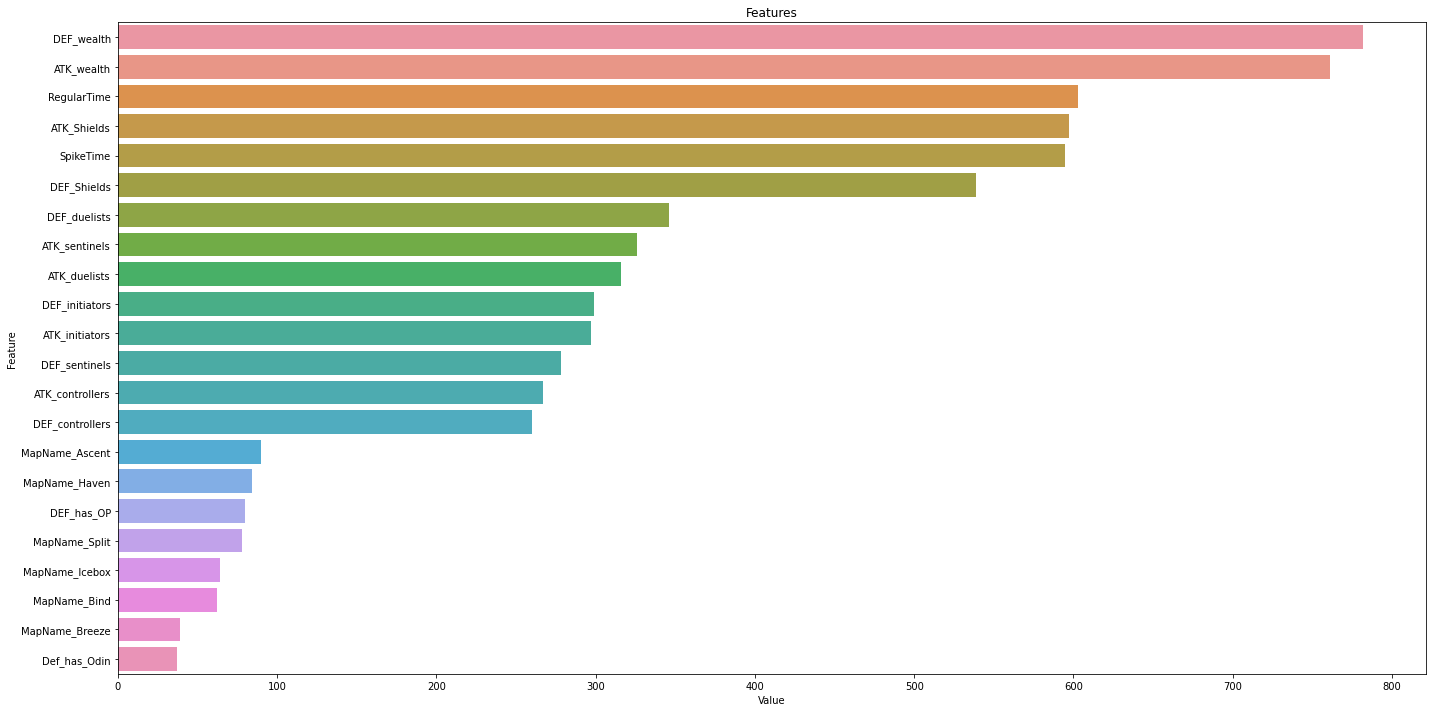

In [14]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

# <font color='blue'>MODEL PRECISION </font>

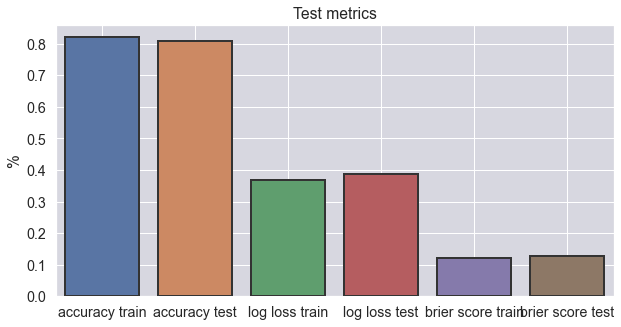

Wall time: 1.24 s


In [15]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [16]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


Brier score → 0.1274428161924825


# <font color='blue'>REALIBITY CURVE </font>

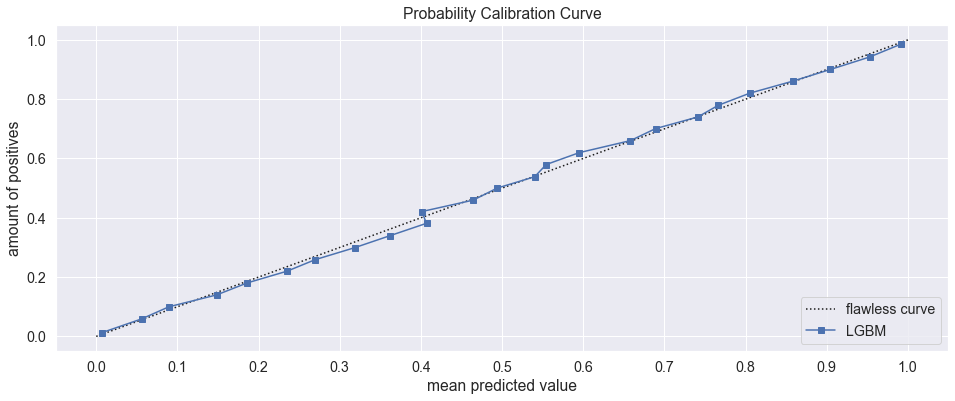

Wall time: 176 ms


Text(0.5, 0, 'mean predicted value')

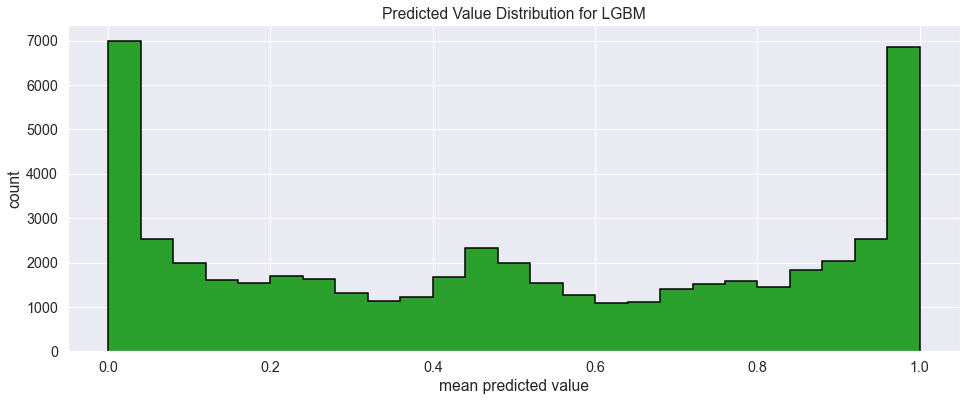

In [17]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

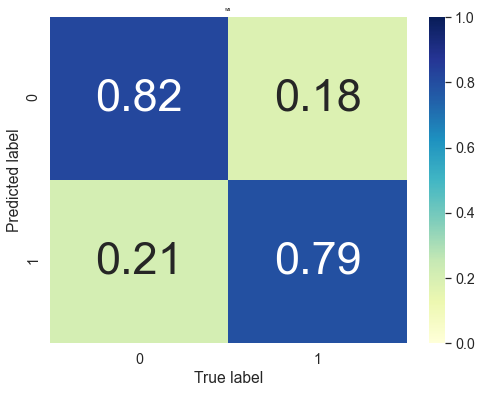

In [18]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [18]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8069097643425968